# Pruning a model (Case: fully connected neural network)

In this practical exercice a fully connected neural network (also called multi-layer perceptron) is built using keras. We explore Magnitude-based weight pruning and its impact in both classification accuracy and size of a compressed file.

Santiago Velasco-Forero
santiago.velasco@mines-paristech.fr

In [3]:
# Run code with tensorflow version 1.x / 2.x
# This has been tested on tensorflow 2.1
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import tensorflow.keras
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.set_cmap('Spectral')
from tensorflow.keras.layers import Activation

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

def get_model(dropout=.5):
    model=tf.keras.Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

model=get_model()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2.1.0-rc1
60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0

<Figure size 432x288 with 0 Axes>

# Magnitude-based weight pruning
 This is the simplest weight pruning algorithm. After each training, the procedure to set to zero, the k_sparsity\% smaller values in absolute value in the weight matrix in each layer. Though this method is very simple, it rarely yields worse results than the more sophisticated algorithms.

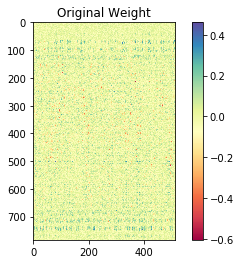

NameError: ignored

In [4]:
k_sparsity=.95
k_weights=model.get_weights()
kernel_weights = k_weights[0]

plt.imshow(kernel_weights)
plt.colorbar()
plt.title('Original Weight')
plt.show()
plt.hist(np.abs(kernel_weights.flatten()))
plt.title('Original Values in Absolute Value')
plt.show()
ind = np.unravel_index(np.argsort(np.abs(kernel_weights),axis=None),kernel_weights.shape)
# Number of indexes to set to 0
cutoff = int(len(ind[0])*k_sparsity)
# The indexes in the 2D kernel weight matrix to set to 0
sparse_cutoff_inds = (ind[0][0:cutoff], ind[1][0:cutoff])
kernel_weights[sparse_cutoff_inds] = 0.
plt.imshow(kernel_weights)
plt.title('After Pruning by Magnitude')
plt.colorbar()
plt.show()
plt.hist(np.abs(kernel_weights.flatten()))
plt.title('Pruned Values in Absolute Value')
plt.show()

### Function to apply Magnitude-based weight prunning in a dense layer.
weight_prune_dense_layer is appllied in both weight matrix and bias vector.

In [0]:
def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    """
    Magnitude-based weight pruning
    
    Takes in matrices of kernel and bias weights (for a dense
      layer) and returns the unit-pruned versions of each
    Args:
      k_weights: 2D matrix of the 
      b_weights: 1D matrix of the biases of a dense layer
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights: sparse matrix with same shape as the original
        kernel weight matrix
      bias_weights: sparse array with same shape as the original
        bias array
    """
    # Copy the kernel weights and get ranked indexes  of the abs
    kernel_weights = np.copy(k_weights)
    ind = np.unravel_index(np.argsort(np.abs(kernel_weights),axis=None),kernel_weights.shape)
        
    # Number of indexes to set to 0
    cutoff = int(len(ind[0])*k_sparsity)
    # The indexes in the 2D kernel weight matrix to set to 0
    sparse_cutoff_inds = (ind[0][0:cutoff], ind[1][0:cutoff])
    kernel_weights[sparse_cutoff_inds] = 0.
        
    # Copy the bias weights and get ranked indexes of the abs
    bias_weights = np.copy(b_weights)
    ind = np.unravel_index(np.argsort(np.abs(bias_weights), axis=None), bias_weights.shape)
        
    # Number of indexes to set to 0
    cutoff = int(len(ind[0])*k_sparsity)
    # The indexes in the 1D bias weight matrix to set to 0
    sparse_cutoff_inds = (ind[0][0:cutoff])
    bias_weights[sparse_cutoff_inds] = 0.
    
    return kernel_weights, bias_weights

### Function to apply a weight prunning in a dense model (dense + dropout). 
Note the prunning in apply each other layer.

In [0]:
def sparsify_model(model, x_test, y_test, k_sparsity, pruning='weight'):
    """
    Takes in a model made of dense layers and prunes the weights
    Args:
      model: Keras model
      k_sparsity: target sparsity of the model
    Returns:
      sparse_model: sparsified copy of the previous model
    """
    # Copying a temporary sparse model from our original
    sparse_model=get_model()
    sparse_model.set_weights(model.get_weights())
    #print(len(sparse_model.layers))
    # Getting a list of the names of each component (w + b) of each layer
    names = [weight.name for layer in sparse_model.layers for weight in layer.weights]
    # Getting the list of the weights for each component (w + b) of each layer
    weights = sparse_model.get_weights()
    
    # Initializing list that will contain the new sparse weights
    newWeightList = []

    # Iterate over all but the final 2 layers (the softmax)
    for i in range(0, len(weights)-1, 2):
        
        if pruning=='weight':
            kernel_weights, bias_weights = weight_prune_dense_layer(weights[i],
                                                                    weights[i+1],
                                                                    k_sparsity)
        elif pruning=='unit':
            kernel_weights, bias_weights = unit_prune_dense_layer(weights[i],
                                                                  weights[i+1],
                                                                  k_sparsity)
            #"unit_prune_dense_layer" is missing function to do in the exercise 1"
        
        elif pruning=='my':
            kernel_weights, bias_weights = myunit_prune_dense_layer(weights[i],
                                                                  weights[i+1],
                                                                  k_sparsity)
            #"myunit_prune_dense_layer" is missing function to do in the exercise 2"
        
        elif pruning=='my':
            kernel_weights, bias_weights = myunit2_prune_dense_layer(weights[i],
                                                                  weights[i+1],
                                                                  k_sparsity)
            #"myunit2_prune_dense_layer" is missing function to do in the exercise 2"
  

        else:
            print('does not match available pruning methods ( weight)')
        
        # Append the new weight list with our sparsified kernel weights
        newWeightList.append(kernel_weights)
        
        # Append the new weight list with our sparsified bias weights
        newWeightList.append(bias_weights)

    # Adding the unchanged weights of the final 2 layers
    for i in range(len(weights), len(weights)):
        unmodified_weight = np.copy(weights[i])
        newWeightList.append(unmodified_weight)

    # Setting the weights of our model to the new ones
    sparse_model.set_weights(newWeightList)
    
    # Re-compiling the Keras model (necessary for using `evaluate()`)
    sparse_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    # Printing the the associated loss & Accuracy for the k% sparsity
    score = sparse_model.evaluate(x_test, y_test, verbose=0)
    print('k% weight sparsity: ', k_sparsity,
          '\tTest loss: {:07.5f}'.format(score[0]),
          '\tTest accuracy: {:05.2f} %%'.format(score[1]*100.))
    
    return sparse_model, score

## Visualizing performance on MNIST
For different values of sparsity "sparsify_model" function computes the test_loss and test_accuracy 

In [0]:
step=2
res_score=[]
for sparsity in range(0,100,step):
    sparse_model, score = sparsify_model(model, x_test=x_test,y_test=y_test,k_sparsity=sparsity/100,pruning='weight')
    res_score.append(score)

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('FIGURE 1. Test Accuracy as a function of k% Sparsity\nfor 3-hidden-layer MLP trained on MNIST')
ax1.plot(np.array(res_score)[:,1],
         '#008fd5', linestyle=':', label='Weight-pruning Acc')
ax2.plot(np.array(res_score)[:,0],
         '#fc4f30', linestyle=':', label='Weight-pruning Loss')
ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);


# Find the best sparsity value
Set best-sparsity according to previous figure.

In [0]:
best_sparsity=25
sparse_model, score = sparsify_model(model, x_test=x_test,y_test=y_test,k_sparsity=best_sparsity/100,pruning='weight')
    

In [0]:
keras_file='original_keras_file.h5'
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
pruned_keras_file='pruned_keras_file.h5'
tf.keras.models.save_model(sparse_model, pruned_keras_file, include_optimizer=False)

## Compare the size files of the unpruned vs. pruned model after compression.
As pruned model contains more zeros the compression rate is more important.

In [0]:
import tempfile
import zipfile
import os
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(keras_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))
_, zip2 = tempfile.mkstemp('.zip') 

with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
print("Size of the pruned model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

The pruned network can be perform even better that unpruned one.

In [0]:
score=model.evaluate(x_test, y_test, verbose=0)
print('\tOriginal Model: Test loss: {:07.5f}'.format(score[0]),'\tTest accuracy: {:05.2f} %%'.format(score[1]*100.))
score=sparse_model.evaluate(x_test, y_test, verbose=0)
print('\tPruned Model: Test loss: {:07.5f}'.format(score[0]),'\tTest accuracy: {:05.2f} %%'.format(score[1]*100.))

# Exercises:

Magnitude-based weight pruning increases the number of zero in both weight matrix and bias vector by simple threshold on the magnitude. However, it should be intereseting to select filters (columns in each weight matrix and value in the bias vector).


1. Design a prunning method by setting to zero the k_sparsity\% columns  with smaller L2-norm. Note that corresponding values in the bias vector should be also set to zero. Create the missing function "unit_prune_dense_layer" in sparsify_model. The following code, can help you to compute the L2-norm per columns.

In [0]:
#Example of computing norm in the columns of a weight matrix
from numpy import linalg as LA
k_weights=model.get_weights()
kernel_weights = k_weights[0]
print('Shape of the Weight Matrix')
print(kernel_weights.shape)
plt.plot(LA.norm(kernel_weights, axis=0))
plt.title('L2-Norm of Columns')
plt.xlabel('Indices')
plt.ylabel('L2-norm')

2. The method in 1 is called "unit pruning layer". Create another method to rank columns and apply prunning as in 1.
(There is not a unique solution, you can imagine your own method). A description of you method should be also included.

3. Previous methods do not take in to consideration the value of bias associated to a filter. Design a pruning method by setting to zero the k_sparsity\% columns taking into consideration both "L2-norm of columns" and corresponding "values" in the bias. Create the missing function "myunit2_dense_layer" in sparsity model. The following code, can help you to have a better understanding of the question. (There is not a unique solution, you can imagine your own method). A description of you method should be also included.

In [0]:
bias_weights = k_weights[1]
print('Shape of the corresponding bias vector')
print(bias_weights.shape)
plt.plot(np.abs(bias_weights))
plt.title('Absolute value of biases')
plt.xlabel('Indices')
plt.ylabel('Absolute Value')

plt.figure()
plt.plot(LA.norm(kernel_weights, axis=0),np.abs(bias_weights),'.')
plt.xlabel('L2-norm of columns')
plt.ylabel('Absolute Value of corresponding bias')

4. Compare your methods in 1., 2. and 3. by means of "Test Accuracy as a function of k% Sparsity" as in Figure 1 . What are your conclusions?
